<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMSkillsNetworkBD0231ENCoursera2789-2023-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


## Final Project - Build an ML Pipeline for Airfoil noise prediction


## Scenario


You are a data engineer at an aeronautics consulting company. Your company prides itself in being able to efficiently design airfoils for use in planes and sports cars. Data scientists in your office need to work with different algorithms and data in different formats. While they are good at Machine Learning, they count on you to be able to do ETL jobs and build ML pipelines. In this project you will use the NASA Airfoil Self Noise dataset. You will clean this dataset, by dropping the duplicate rows, and removing the rows with null values. You will create an ML pipeline to create a model that will predict the SoundLevel based on all the other columns. You will evaluate the model and towards the end you will persist the model.



## Objectives

In this 4 part assignment you will:

- Part 1 Perform ETL activity
  - Load a csv dataset
  - Remove duplicates if any
  - Drop rows with null values if any
  - Make transformations
  - Store the cleaned data in parquet format
- Part 2 Create a  Machine Learning Pipeline
  - Create a machine learning pipeline for prediction
- Part 3 Evaluate the Model
  - Evaluate the model using relevant metrics
- Part 4 Persist the Model 
  - Save the model for future production use
  - Load and verify the stored model
- Part 5 Cross Validation
  - Create a parameters grid
  - Execute the cross-validation
  - Save the model for future production use
  - Load and verify the stored model
- Part 6 StopSpark Context and Session
  - Stop the context and session

## Datasets

In this lab you will be using dataset(s):

 - The original dataset can be found here NASA airfoil self noise dataset. https://archive.ics.uci.edu/dataset/291/airfoil+self+noise
 
 - This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.


Diagram of an airfoil. - For informational purpose


![Airfoil with flow](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-BD0231EN-Coursera/images/Airfoil_with_flow.png)


Diagram showing the Angle of attack. - For informational purpose


![Airfoil angle of attack](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-BD0231EN-Coursera/images/Airfoil_angle_of_attack.jpg)


## Setup


For this lab, we will be using the following libraries:

*   [`PySpark`](https://spark.apache.org/docs/latest/api/python/index.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMSkillsNetworkBD0231ENCoursera2789-2023-01-01) for connecting to the Spark Cluster


### Installing Required Libraries
Install pyspark and findspark if not install:
- ```%pip install pyspark -q```<br>
- ```%pip install findspark -q```


## Importing Required Libraries

In [1]:
# Suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# FindSpark simplifies the process of using Apache Spark with Python
import findspark
findspark.init()

## Part 1 - Perform ETL activity


### Task 1 - Import required libraries


In [2]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression, FMRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator


### Task 2 - Create a spark session


In [4]:
#Create a SparkSession
conf = SparkConf()
conf.set("spark.executor.memory", "2g")
sc = SparkContext(conf=conf)
spark = SparkSession.builder.appName('Final Project').getOrCreate()
sc.setLogLevel("error")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/30 17:38:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Task 3 - Load the csv file into a dataframe


Download the data file.

NOTE : Please ensure you use the dataset below and not the original dataset mentioned above.


In [5]:
from pathlib import Path
from zipfile import ZipFile


dataPath = Path('airfoil+self+noise.zip')

if not dataPath.exists():
    !wget https://archive.ics.uci.edu/static/public/291/airfoil+self+noise.zip
    with ZipFile(dataPath, "r") as zip_ref:
        zip_ref.extractall()
else:
    print('Dataset already downloaded and unzip')

Dataset already downloaded and unzip


Load the dataset into the spark dataframe


In [6]:
# Load the dataset that you have downloaded in the previous task
df = spark.read.csv("airfoil_self_noise.dat", header=False, sep='\t')

### Task 4 - Print top 5 rows of the dataset


In [7]:
# Display dataframe content
df.show(5)

+----+---+------+----+----------+-------+
| _c0|_c1|   _c2| _c3|       _c4|    _c5|
+----+---+------+----+----------+-------+
| 800|  0|0.3048|71.3|0.00266337|126.201|
|1000|  0|0.3048|71.3|0.00266337|125.201|
|1250|  0|0.3048|71.3|0.00266337|125.951|
|1600|  0|0.3048|71.3|0.00266337|127.591|
|2000|  0|0.3048|71.3|0.00266337|127.461|
+----+---+------+----+----------+-------+
only showing top 5 rows



In [8]:
# Print the Schema
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)



In [9]:
# Define a Schema for the input data and read the file using the user-defined Schema
from pyspark.sql.types import StructField, StructType, IntegerType, FloatType

schema = StructType([
    StructField('Frequency', IntegerType(), nullable=False),
    StructField('AngleOfAttack', FloatType(), nullable=False),
    StructField('ChordLength', FloatType(), nullable=False),
    StructField('FreeStreamVelocity', FloatType(), nullable=False),
    StructField('SuctionSideDisplacement', FloatType(), nullable=False),
    StructField('SoundLevel', FloatType(), nullable=False)]
  )

df = (spark.read.format("csv")
      .schema(schema)
      .option("header", "false")
      .load("airfoil_self_noise.dat", sep="\t"))

In [10]:
df.show(5)

+---------+-------------+-----------+------------------+-----------------------+----------+
|Frequency|AngleOfAttack|ChordLength|FreeStreamVelocity|SuctionSideDisplacement|SoundLevel|
+---------+-------------+-----------+------------------+-----------------------+----------+
|      800|          0.0|     0.3048|              71.3|             0.00266337|   126.201|
|     1000|          0.0|     0.3048|              71.3|             0.00266337|   125.201|
|     1250|          0.0|     0.3048|              71.3|             0.00266337|   125.951|
|     1600|          0.0|     0.3048|              71.3|             0.00266337|   127.591|
|     2000|          0.0|     0.3048|              71.3|             0.00266337|   127.461|
+---------+-------------+-----------+------------------+-----------------------+----------+
only showing top 5 rows



In [11]:
# Verify the Schema changes
df.printSchema()

root
 |-- Frequency: integer (nullable = true)
 |-- AngleOfAttack: float (nullable = true)
 |-- ChordLength: float (nullable = true)
 |-- FreeStreamVelocity: float (nullable = true)
 |-- SuctionSideDisplacement: float (nullable = true)
 |-- SoundLevel: float (nullable = true)



### Task 6 - Print the total number of rows in the dataset


In [12]:
#your code goes here
rowcount1 = df.count()
print(rowcount1)

1503


### Task 7 - Drop all the duplicate rows from the dataset


In [13]:
df = df.dropDuplicates()

### Task 8 - Print the total number of rows in the dataset


In [14]:
#your code goes here
rowcount2 = df.count()
print(rowcount2)

1503


### Task 9 - Drop all the rows that contain null values from the dataset


In [15]:
df = df.dropna()

### Task 10 - Print the total number of rows in the dataset


In [16]:
rowcount3 = df.count()
print(rowcount3)

1503


### Task 11a - Rename the column "SoundLevel" to "SoundLevelDecibels"


In [17]:
df = df.withColumnRenamed("SoundLevel", "SoundLevelDecibels")

### Task 11b - Show the correlation within column

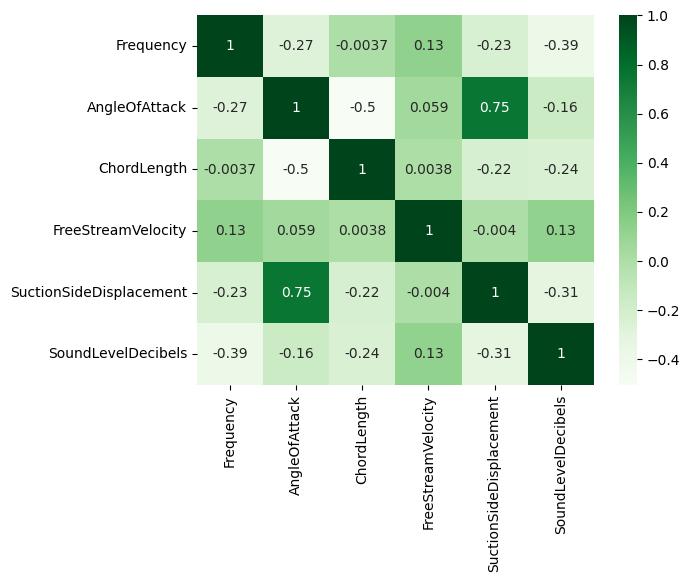

In [18]:
import seaborn as sns
corrMatrix = df.toPandas().corr()
ax = sns.heatmap(corrMatrix, cmap="Greens", annot=True)

- __SuctionSideDisplacement__ and __AngleOfAttack__ are highly correlated (0.75).

### Task 12 - Save the dataframe in parquet formant, name the file as "NASA_airfoil_noise_cleaned.parquet"


In [19]:
# your code goes here
df.write.mode("overwrite").parquet("NASA_airfoil_noise_cleaned.parquet")

### Part 1 - Evaluation


In [20]:
import os

In [21]:
print("Part 1 - Evaluation")
print("Total rows = ", rowcount1)
print("Total rows after dropping duplicate rows = ", rowcount2)
print("Total rows after dropping duplicate rows and rows with null values = ", rowcount3)
print("New column name = ", df.columns[-1])
print("NASA_airfoil_noise_cleaned.parquet exists:", os.path.isdir("NASA_airfoil_noise_cleaned.parquet"))

Part 1 - Evaluation
Total rows =  1503
Total rows after dropping duplicate rows =  1503
Total rows after dropping duplicate rows and rows with null values =  1503
New column name =  SoundLevelDecibels
NASA_airfoil_noise_cleaned.parquet exists: True


## Part - 2 Create a  Machine Learning Pipeline


### Task 1 - Load data from "NASA_airfoil_noise_cleaned.parquet" into a dataframe


In [22]:
df = spark.read.parquet("NASA_airfoil_noise_cleaned.parquet")

### Task 2 - Print the total number of rows in the dataset


In [23]:
rowcount4 = df.count()
print(rowcount4)

1503


### Task 3 - Define the VectorAssembler pipeline stage


Stage 1 - Assemble the input columns into a single column "features". Use all the columns except SoundLevelDecibels as input features.


In [24]:
# Assembles columns 0-4
assembler = VectorAssembler(inputCols=df.columns[0:-1], outputCol='features')

### Task 4 - Define the StandardScaler pipeline stage


Stage 2 - Scale the "features" using standard scaler and store in "scaledFeatures" column


In [25]:
scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures')

### Task 5 - Define the StandardScaler pipeline stage


Stage 3 - Create a LinearRegression stage to predict "SoundLevelDecibels"

**Note**:Use the ```ScaledFeatures``` retreived in the previous step.


In [26]:
# Define the models
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="SoundLevelDecibels", regParam=0.2, elasticNetParam=0.8)
factRegressor = FMRegressor(featuresCol="scaledFeatures", labelCol="SoundLevelDecibels", stepSize=0.3)
randomForest = RandomForestRegressor(featuresCol="scaledFeatures", labelCol="SoundLevelDecibels", maxDepth=8)
gradientBoost = GBTRegressor(featuresCol="scaledFeatures", labelCol="SoundLevelDecibels", maxDepth=8)

### Task 6 - Build the pipeline


Build a pipeline using the above three stages


In [27]:
# Build the pipelines
lrPipeline = Pipeline(stages=[assembler, scaler, lr])
fmPipeline = Pipeline(stages=[assembler, scaler, factRegressor])
forestPipeline = Pipeline(stages=[assembler, scaler, randomForest])
gboostPipeline = Pipeline(stages=[assembler, scaler, gradientBoost])

### Task 7 - Split the data


In [28]:
# Split the data into training and testing sets with 70:30 split.
(trainingData, testingData) = df.randomSplit([0.7, 0.3], seed=42)
(testingData, valData) = testingData.randomSplit([0.6, 0.4], seed=42)

### Task 8 - Fit the pipeline


In [29]:
# Fit the pipeline using the training data
pipelineLinearModel = lrPipeline.fit(trainingData)
pipelineFMRegModel = fmPipeline.fit(trainingData)
pipelineForestModel = forestPipeline.fit(trainingData)
pipelineGBoostModel = gboostPipeline.fit(trainingData)

### Part 2 - Evaluation


In [30]:
print("Part 2 - Evaluation Linear Regression")
print("Total rows = ", rowcount4)
ps = [str(x).split("_")[0] for x in lrPipeline.getStages()]

print("Pipeline Stage 1 = ", ps[0])
print("Pipeline Stage 2 = ", ps[1])
print("Pipeline Stage 3 = ", ps[2])

print("Label column = ", lr.getLabelCol())


Part 2 - Evaluation Linear Regression
Total rows =  1503
Pipeline Stage 1 =  VectorAssembler
Pipeline Stage 2 =  MinMaxScaler
Pipeline Stage 3 =  LinearRegression
Label column =  SoundLevelDecibels


In [31]:
print("Part 2 - Evaluation Factorization Machines")
print("Total rows = ", rowcount4)
ps = [str(x).split("_")[0] for x in fmPipeline.getStages()]

print("Pipeline Stage 1 = ", ps[0])
print("Pipeline Stage 2 = ", ps[1])
print("Pipeline Stage 3 = ", ps[2])

print("Label column = ", factRegressor.getLabelCol())

Part 2 - Evaluation Factorization Machines
Total rows =  1503
Pipeline Stage 1 =  VectorAssembler
Pipeline Stage 2 =  MinMaxScaler
Pipeline Stage 3 =  FMRegressor
Label column =  SoundLevelDecibels


In [32]:
print("Part 2 - Evaluation Random Forest")
print("Total rows = ", rowcount4)
ps = [str(x).split("_")[0] for x in forestPipeline.getStages()]

print("Pipeline Stage 1 = ", ps[0])
print("Pipeline Stage 2 = ", ps[1])
print("Pipeline Stage 3 = ", ps[2])

print("Label column = ", randomForest.getLabelCol())


Part 2 - Evaluation Random Forest
Total rows =  1503
Pipeline Stage 1 =  VectorAssembler
Pipeline Stage 2 =  MinMaxScaler
Pipeline Stage 3 =  RandomForestRegressor
Label column =  SoundLevelDecibels


In [33]:
print("Part 2 - Evaluation Gradient Boosted")
print("Total rows = ", rowcount4)
ps = [str(x).split("_")[0] for x in gboostPipeline.getStages()]

print("Pipeline Stage 1 = ", ps[0])
print("Pipeline Stage 2 = ", ps[1])
print("Pipeline Stage 3 = ", ps[2])

print("Label column = ", gradientBoost.getLabelCol())

Part 2 - Evaluation Gradient Boosted
Total rows =  1503
Pipeline Stage 1 =  VectorAssembler
Pipeline Stage 2 =  MinMaxScaler
Pipeline Stage 3 =  GBTRegressor
Label column =  SoundLevelDecibels


## Part 3 - Evaluate the Model


### Task 1 - Predict using the model


In [34]:
# Make predictions on testing data
lrPredictions = pipelineLinearModel.transform(valData)

In [35]:
lrPredictions.select("prediction", "SoundLevelDecibels").show(5)

+------------------+------------------+
|        prediction|SoundLevelDecibels|
+------------------+------------------+
|123.26644180102792|           128.679|
| 129.9325220659013|           119.146|
|126.58923459080097|           134.319|
|129.99889982626866|           125.941|
|121.30205276098671|           128.354|
+------------------+------------------+
only showing top 5 rows



In [36]:
factPredictions = pipelineFMRegModel.transform(valData)

In [37]:
factPredictions.select("prediction", "SoundLevelDecibels").show(5)

+------------------+------------------+
|        prediction|SoundLevelDecibels|
+------------------+------------------+
|107.21797295918647|           128.679|
|30.041915316913254|           119.146|
|150.03748422043006|           134.319|
| 91.79197685089764|           125.941|
| 181.0580471870224|           128.354|
+------------------+------------------+
only showing top 5 rows



In [38]:
forestPredictions = pipelineForestModel.transform(valData)

In [39]:
forestPredictions.select("prediction", "SoundLevelDecibels").show(5)

+------------------+------------------+
|        prediction|SoundLevelDecibels|
+------------------+------------------+
|126.77429627950748|           128.679|
|124.55243583893484|           119.146|
|130.83774951476067|           134.319|
|129.42209524783271|           125.941|
| 124.6473869117472|           128.354|
+------------------+------------------+
only showing top 5 rows



In [40]:
gboostPredictions = pipelineGBoostModel.transform(valData)

In [41]:
gboostPredictions.select("prediction", "SoundLevelDecibels").show(5)

+------------------+------------------+
|        prediction|SoundLevelDecibels|
+------------------+------------------+
|128.39288543811273|           128.679|
|120.53315444797046|           119.146|
|133.20323877273347|           134.319|
|131.54829254980675|           125.941|
|128.87627174414462|           128.354|
+------------------+------------------+
only showing top 5 rows



### Task 2 - Print the MSE


In [42]:
#TODO
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SoundLevelDecibels', metricName='mse')
mse = evaluator.evaluate(lrPredictions)
mse_fact = evaluator.evaluate(factPredictions)
mse_forest = evaluator.evaluate(forestPredictions)
mse_gboost = evaluator.evaluate(gboostPredictions)
print(f'Linear Regression mse: {mse:.2f}')
print(f'Factorization Machines mse: {mse_fact:.2f}')
print(f'Random Forest mse: {mse_forest:.2f}')
print(f'Gradient Boosted mse: {mse_gboost: .2f}')

Linear Regression mse: 26.38
Factorization Machines mse: 3243.89
Random Forest mse: 9.79
Gradient Boosted mse:  5.82


### Task 3 - Print the MAE


In [43]:
# TO DO
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SoundLevelDecibels', metricName='mae')
mae = evaluator.evaluate(lrPredictions)
mae_fact = evaluator.evaluate(factPredictions)
mae_forest = evaluator.evaluate(forestPredictions)
mae_gboost = evaluator.evaluate(gboostPredictions)
print(f'Linear Regression mae: {mae:.2f}')
print(f'Factorization Machines mae: {mae_fact:.2f}')
print(f'Random Forest mae: {mae_forest:.2f}')
print(f'Gradient Boosted mae: {mae_gboost: .2f}')

Linear Regression mae: 4.02
Factorization Machines mae: 48.46
Random Forest mae: 2.37
Gradient Boosted mae:  1.71


### Task 4 - Print the R-Squared(R2)


In [44]:
#TODO
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SoundLevelDecibels', metricName='r2')
r2 = evaluator.evaluate(lrPredictions)
r2_fact = evaluator.evaluate(factPredictions)
r2_forest = evaluator.evaluate(forestPredictions)
r2_gboost = evaluator.evaluate(gboostPredictions)
print(f'Linear Regression r-squared: {r2:.2}')
print(f'Factorization Machines r-squared: {r2_fact:.2}')
print(f'Random Forest r-squared: {r2_forest:.2}')
print(f'Gradient Boosted r-squared: {r2_gboost:.2}')

Linear Regression r-squared: 0.42
Factorization Machines r-squared: -7e+01
Random Forest r-squared: 0.79
Gradient Boosted r-squared: 0.87


In [45]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='SoundLevelDecibels', metricName="rmse")
rmse = evaluator.evaluate(lrPredictions)
rmse_fact = evaluator.evaluate(factPredictions)
rmse_forest = evaluator.evaluate(forestPredictions)
rmse_gboost = evaluator.evaluate(gboostPredictions)
print(f'Linear Regression rmse: {rmse:.2}')
print(f'Factorization Machines rmse: {rmse_fact:.2}')
print(f'Random Forest rmse: {rmse_forest:.2}')
print(f'Gradient Boosted rmse: {rmse_gboost:.2}')

Linear Regression rmse: 5.1
Factorization Machines rmse: 5.7e+01
Random Forest rmse: 3.1
Gradient Boosted rmse: 2.4


### Part 3 - Evaluation


In [46]:
print("Part 3 - Evaluation Linear Regression")
print("Mean Squared Error:", round(mse, 2))
print("Mean Absolute Error:", round(mae, 2))
print("R Squared:", round(r2, 2))
print("RMSE:", round(rmse, 2))

lrModel = pipelineLinearModel.stages[-1]
print("Intercept:", round(lrModel.intercept, 2))

Part 3 - Evaluation Linear Regression
Mean Squared Error: 26.38
Mean Absolute Error: 4.02
R Squared: 0.42
RMSE: 5.14
Intercept: 133.51


In [47]:
print("Part 3 - Evaluation Factorization Machines")
print("Mean Squared Error:", round(mse_fact, 2))
print("Mean Absolute Error:", round(mae_fact, 2))
print("R Squared:", round(r2_fact, 2))
print("RMSE =", round(rmse_fact, 2))

fmModel = pipelineFMRegModel.stages[-1]
print("Coefficients:", fmModel.linear)
print("Intercept:", fmModel.intercept)

Part 3 - Evaluation Factorization Machines
Mean Squared Error: 3243.89
Mean Absolute Error: 48.46
R Squared: -69.84
RMSE = 56.96
Coefficients: [17.11706730684118,16.7651120990446,17.688614450805986,13.441914843764737,9.110124161990356]
Intercept: 21.47650563641079


In [48]:
print("Part 3 - Evaluation Random Forest")

print("Mean Squared Error:", round(mse_forest, 2))
print("Mean Absolute Erro:", round(mae_forest, 2))
print("R Square:", round(r2_forest, 2))
print("RMSE:", round(rmse_forest, 2))

forestModel = pipelineForestModel.stages[-1]
# print("Coefficients: ", forestModel.linear)
print("Feature Importances:", forestModel.featureImportances)

Part 3 - Evaluation Random Forest
Mean Squared Error: 9.79
Mean Absolute Erro: 2.37
R Square: 0.79
RMSE: 3.13
Feature Importances: (5,[0,1,2,3,4],[0.4438057881280176,0.09487653126551464,0.16288654711734413,0.049850550669726386,0.2485805828193973])


In [49]:
print("Part 3 - Evaluation Gradient Boosted")

print("Mean Squared Error:", round(mse_gboost, 2))
print("Mean Absolute Error:", round(mae_gboost, 2))
print("R Squared:", round(r2_gboost, 2))
print("RMSE:", round(rmse_gboost, 2))

gboostModel = pipelineGBoostModel.stages[-1]
print(gboostModel.featureImportances)

Part 3 - Evaluation Gradient Boosted
Mean Squared Error: 5.82
Mean Absolute Error: 1.71
R Squared: 0.87
RMSE: 2.41
(5,[0,1,2,3,4],[0.38226406528441936,0.12182328757118391,0.11892432024114606,0.07343539513283412,0.3035529317704166])


## Part 4 - Persist the Model


### Task 1 - Save the model to the path "Final_Project"


In [50]:
# Save the pipeline model as "Final_Project"
pipelineLinearModel.write().overwrite().save("Final_Project_Linear")
pipelineFMRegModel.write().overwrite().save("Final_Project_Factorization_Machines")
pipelineForestModel.write().overwrite().save("Final_Project_Forest")
pipelineGBoostModel.write().overwrite().save("Final_Project_Gboost")

### Task 2 - Load the model from the path "Final_Project"


In [51]:
# Load the pipeline model you have created in the previous step
loadedPipelineModel = PipelineModel.load("Final_Project_Linear")
loadedPipelineModelFM = PipelineModel.load("Final_Project_Factorization_Machines")
loadedPipelineModelForest = PipelineModel.load("Final_Project_Forest")
loadedPipelineModelGboost = PipelineModel.load("Final_Project_Gboost")

### Task 3 - Make predictions using the loaded model on the testdata

In [52]:
# Use the loaded pipeline model and make predictions using testingData
predictionsLR = loadedPipelineModel.transform(testingData)
predictionsFM = loadedPipelineModelFM.transform(testingData)
predictionsForest = loadedPipelineModelForest.transform(testingData)
predictionsGB = loadedPipelineModelGboost.transform(testingData)

### Task 4 - Show the predictions


In [53]:
# Show top 5 rows from the predections dataframe and display only the label column and predictions
predictionsLR.select("prediction", "SoundLevelDecibels").show(5)

+------------------+------------------+
|        prediction|SoundLevelDecibels|
+------------------+------------------+
|127.21468335335094|            133.42|
|130.50785057801005|           116.074|
|127.61169798855798|            125.01|
|125.13018689501821|           130.588|
| 125.5733905968652|            122.94|
+------------------+------------------+
only showing top 5 rows



In [54]:
predictionsFM.select("prediction", "SoundLevelDecibels").show(5)

+------------------+------------------+
|        prediction|SoundLevelDecibels|
+------------------+------------------+
| 74.54392690501598|            133.42|
|37.595470370418354|           116.074|
|57.453628514290834|            125.01|
| 136.9652645914776|           130.588|
| 93.65544054419696|            122.94|
+------------------+------------------+
only showing top 5 rows



In [55]:
predictionsForest.select("prediction", "SoundLevelDecibels").show(5)

+------------------+------------------+
|        prediction|SoundLevelDecibels|
+------------------+------------------+
|131.10998823363116|            133.42|
|124.60056489383416|           116.074|
|128.20177278330794|            125.01|
|130.61595790323616|           130.588|
|127.03812744074155|            122.94|
+------------------+------------------+
only showing top 5 rows



In [56]:
predictionsGB.select("prediction", "SoundLevelDecibels").show(5)

+------------------+------------------+
|        prediction|SoundLevelDecibels|
+------------------+------------------+
| 134.0586061639062|            133.42|
| 120.7773693227864|           116.074|
|127.58060526939983|            125.01|
|131.34152551611487|           130.588|
|123.43953435529811|            122.94|
+------------------+------------------+
only showing top 5 rows



### Part 4 - Evaluation



Print the models coefficients.<br>

In [57]:
test_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SoundLevelDecibels', metricName='rmse')

In [58]:
print("Part 4 - Evaluation on test set")

test_rmse = test_evaluator.evaluate(predictionsLR)
test_rmse_fact = test_evaluator.evaluate(predictionsFM)
test_rmse_forest = test_evaluator.evaluate(predictionsForest)
test_rmse_gboost = test_evaluator.evaluate(predictionsGB)

print(f'Linear Regression rmse: {test_rmse:.2f}')
print(f'FM Regression rmse: {test_rmse_fact:.2f}')
print(f'Random Forest Regression rmse: {test_rmse_forest:.2f}')
print(f'GBoost Regression rmse: {test_rmse_gboost:.2f}')


Part 4 - Evaluation on test set
Linear Regression rmse: 4.90
Linear Regression rmse: 54.17
Linear Regression rmse: 3.14
Linear Regression rmse: 2.87


In [59]:
test_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SoundLevelDecibels', metricName='r2')

In [60]:
print("Part 4 - Evaluation on test set")

test_r2 = test_evaluator.evaluate(predictionsLR)
test_r2_fact = test_evaluator.evaluate(predictionsFM)
test_r2_forest = test_evaluator.evaluate(predictionsForest)
test_r2_gboost = test_evaluator.evaluate(predictionsGB)

print(f'Linear Regression r2: {test_r2:.2f}')
print(f'FM Regression r2: {test_r2_fact:.2f}')
print(f'Random Forest r2: {test_r2_forest:.2f}')
print(f'GBoost Regression r2: {test_r2_gboost:.2f}')

Part 4 - Evaluation on test set
Linear Regression r2: 0.57
FM Regression r2: -51.66
Random Forest Regression r2: 0.82
GBoost Regression r2: 0.85


In [61]:
loadedPipelineModelGboost.stages

[VectorAssembler_65339b69ec77,
 MinMaxScalerModel: uid=MinMaxScaler_2757cd2429dc, numFeatures=5, min=0.0, max=1.0,
 GBTRegressionModel: uid=GBTRegressor_4f565819c1d0, numTrees=20, numFeatures=5]

## Part 5 - Fine-tune the best Model with Cross Validation

In [62]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel

### Task 1 - Create then Parameter Grid and run the Cross Vaidation

In [65]:
# Split data
trainingData, testingData = df.randomSplit([0.7, 0.3], seed=42)

# build the evaluator to optimise
gbEvaluator = RegressionEvaluator(predictionCol='prediction', labelCol='SoundLevelDecibels', metricName="rmse")

# Create ParamGrid for Cross Validation
grid = ParamGridBuilder().addGrid(gradientBoost.maxDepth, [5, 8, 10, 12])\
               .addGrid(gradientBoost.maxBins, [25, 32, 40])\
                .addGrid(gradientBoost.maxIter, [15, 20, 25])\
                .build()

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=gboostPipeline,
                      estimatorParamMaps=grid,
                      evaluator=gbEvaluator,
                      numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
print(cvModel)
print(cvModel.avgMetrics)

CrossValidatorModel_c7923f4022cd
[3.1580648777048945, 2.972805048494963, 2.833692829985218, 3.123320979927945, 2.9432067578906875, 2.7907546331345143, 3.0577813440654715, 2.8791086861748463, 2.7335327775354905, 2.747584492011979, 2.699202694413022, 2.6647148585023905, 2.7478373968641256, 2.6984229679011262, 2.6707967655391176, 2.7959158248298217, 2.7411648376668505, 2.6815820528371113, 2.935686329088844, 2.9216861064701964, 2.915950421652582, 2.951209259425547, 2.938763861087627, 2.9319875845681707, 2.8083215359208165, 2.7955078176366777, 2.789618942742679, 2.9726265014316593, 2.971734320012491, 2.9713486765547232, 3.0218198626162316, 3.0207910067152346, 3.0208506644143798, 2.9664260194665095, 2.9671625650359217, 2.966269869851743]


### Task 2 - Model Persistance

In [66]:
from datetime import datetime
# current date and time
now = datetime.now()

# convert from datetime to timestamp
ts = datetime.timestamp(now)
path = f'optim_gboost_model_{ts}'
cvModel.write().save(path)

### Task 3 - Best Model Parameters

In [67]:
bestModel = cvModel.bestModel
bestModel.stages[-1].params

[Param(parent='GBTRegressor_4f565819c1d0', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'),
 Param(parent='GBTRegressor_4f565819c1d0', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'),
 Param(parent='GBTRegressor_4f565819c1d0', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'a

In [68]:
print(f"MaxIter: {bestModel.stages[-1].getMaxIter()}")
print(f"MaxDepth: {bestModel.stages[-1].getMaxDepth()}")
print(f"MaxBins: {bestModel.stages[-1].getMaxBins()}")

MaxIter: 25
MaxDepth: 8
MaxBins: 25


### Task 4 - Predict using the best model

In [69]:
# Loads Model
cvModelRead = CrossValidatorModel.read().load(path)

# Use test set to measure the accuracy of the model in the test data
cvPredictions = cvModelRead.transform(testingData)
cvRMSE = gbEvaluator.evaluate(cvPredictions)
r2_eval = RegressionEvaluator(predictionCol='prediction', labelCol='SoundLevelDecibels', metricName="r2")
cvR2 = r2_eval.evaluate(cvPredictions)


# Evaluate best model
print(f'RMSE: {cvRMSE:.2f}')
print(f'R2: {cvR2:.2f}')


RMSE: 2.60
R2: 0.87


## Part 6 - Stop Spark Context and Session


In [70]:
sc.stop()
spark.stop()